# imports

In [1]:
library(tidyverse)
library(dplyr)
library(data.table)
library(spatstat)

library(xgboost)
library(gbm)

library(rpart)
library(caret)

library(Metrics)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'data.table' was built under R version 3.6.3"
Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose

Warning message:
"package 'spatstat' was built under R version 3.6.3"Loading required package: spatstat.data
W

In [2]:
cl_data <- read_csv("../datasets/Dataset 3 Beijing/Datacleaning/cleaned_beijing.csv")
#cl_data <- read_csv("cleaned_beijing.csv")
cl_data <- cl_data[ -c(1) ]

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  tradeTime = col_date(format = ""),
  buildingType = col_character(),
  renovationCondition = col_character(),
  buildingStructure = col_character(),
  elevator = col_character(),
  fiveYearsProperty = col_character(),
  subway = col_character(),
  district = col_character()
)
See spec(...) for full column specifications.


In [3]:
head(cl_data)

Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
116.4755,40.01952,1.111027e+12,2016-08-09,1464,106,415.0,31680,131.00,2,...,Tower,2005,Simplicit,Steel/Concrete,0.217,Has_Elevator,Ownership > 5y,Has_Subway,ChaoYang,56021
116.4539,39.88153,1.111027e+12,2016-07-28,903,126,575.0,43436,132.38,2,...,Tower,2004,Hardcover,Steel/Concrete,0.667,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,71539
116.5620,39.87714,1.111041e+12,2016-12-11,1271,48,1030.0,52021,198.00,3,...,Plate,2005,Simplicit,Steel/Concrete,0.500,Has_Elevator,Ownership > 5y,No_Subway,ChaoYang,48160
116.4380,40.07611,1.111043e+12,2016-09-30,965,138,297.5,22202,134.00,3,...,Tower,2008,Other,Steel/Concrete,0.273,Has_Elevator,Ownership > 5y,No_Subway,ChangPing,51238
116.4284,39.88623,1.111027e+12,2016-08-28,927,286,392.0,48396,81.00,2,...,Plate,1960,Rough,Mixed,0.333,No_elevator,Ownership < 5y,Has_Subway,DongCheng,62588
116.4663,39.99136,1.111027e+12,2016-07-22,861,57,275.6,52000,53.00,1,...,Plate,2005,Simplicit,Steel/Concrete,0.333,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,67738


In [4]:
summary(cl_data)

      Lng             Lat             Cid              tradeTime         
 Min.   :116.1   Min.   :39.63   Min.   :1.111e+12   Min.   :2002-06-01  
 1st Qu.:116.3   1st Qu.:39.89   1st Qu.:1.111e+12   1st Qu.:2013-12-26  
 Median :116.4   Median :39.93   Median :1.111e+12   Median :2015-09-27  
 Mean   :116.4   Mean   :39.95   Mean   :1.126e+12   Mean   :2015-04-30  
 3rd Qu.:116.5   3rd Qu.:40.00   3rd Qu.:1.111e+12   3rd Qu.:2016-08-12  
 Max.   :116.7   Max.   :40.25   Max.   :1.185e+14   Max.   :2018-01-28  
      DOM            followers         totalPrice         price       
 Min.   :   1.00   Min.   :   0.00   Min.   :  13.0   Min.   : 10000  
 1st Qu.:   7.00   1st Qu.:   0.00   1st Qu.: 206.0   1st Qu.: 28362  
 Median :   7.00   Median :   5.00   Median : 295.0   Median : 39133  
 Mean   :  18.54   Mean   :  17.25   Mean   : 350.6   Mean   : 44003  
 3rd Qu.:   8.00   3rd Qu.:  19.00   3rd Qu.: 428.0   3rd Qu.: 54348  
 Max.   :1677.00   Max.   :1143.00   Max.   :4900.0   Ma

In [5]:
unique(cl_data$constructionTime)

[1] 2005 2004 2008 1960 1997 2009 1991 2001 1990 2011 2000 1998 2010 1996 1993
[16] 2006 2002 2012 1989 2003 2007 1994 1984 1992 2014 1985 1999 1979 1981 1976
[31] 1982 1975 1983 1986 1995 1965 2013 1988 1987 2015 1955 1980 1978 1958 1970
[46] 1956 1977 1964 1963 1967 2016 1974 1973 1959 1954 1962 1966 1957 1972 1971
[61] 1953 1968 1961 1950 1952 1969

removing  Cid and total price. cid has too many factors (computer crashes when trained using as factor) 

In [6]:
data = cl_data[-c(3,7)]

# Data After Modifiation

In [7]:
head(data)

Lng,Lat,tradeTime,DOM,followers,price,square,livingRoom,drawingRoom,kitchen,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
116.4755,40.01952,2016-08-09,1464,106,31680,131.00,2,1,1,...,Tower,2005,Simplicit,Steel/Concrete,0.217,Has_Elevator,Ownership > 5y,Has_Subway,ChaoYang,56021
116.4539,39.88153,2016-07-28,903,126,43436,132.38,2,2,1,...,Tower,2004,Hardcover,Steel/Concrete,0.667,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,71539
116.5620,39.87714,2016-12-11,1271,48,52021,198.00,3,2,1,...,Plate,2005,Simplicit,Steel/Concrete,0.500,Has_Elevator,Ownership > 5y,No_Subway,ChaoYang,48160
116.4380,40.07611,2016-09-30,965,138,22202,134.00,3,1,1,...,Tower,2008,Other,Steel/Concrete,0.273,Has_Elevator,Ownership > 5y,No_Subway,ChangPing,51238
116.4284,39.88623,2016-08-28,927,286,48396,81.00,2,1,1,...,Plate,1960,Rough,Mixed,0.333,No_elevator,Ownership < 5y,Has_Subway,DongCheng,62588
116.4663,39.99136,2016-07-22,861,57,52000,53.00,1,0,1,...,Plate,2005,Simplicit,Steel/Concrete,0.333,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,67738


In [8]:
colnames(data)

[1] "Lng"                 "Lat"                 "tradeTime"          
 [4] "DOM"                 "followers"           "price"              
 [7] "square"              "livingRoom"          "drawingRoom"        
[10] "kitchen"             "bathRoom"            "floor"              
[13] "buildingType"        "constructionTime"    "renovationCondition"
[16] "buildingStructure"   "ladderRatio"         "elevator"           
[19] "fiveYearsProperty"   "subway"              "district"           
[22] "communityAverage"

In [9]:
str(data)

Classes 'tbl_df', 'tbl' and 'data.frame':	296350 obs. of  22 variables:
 $ Lng                : num  116 116 117 116 116 ...
 $ Lat                : num  40 39.9 39.9 40.1 39.9 ...
 $ tradeTime          : Date, format: "2016-08-09" "2016-07-28" ...
 $ DOM                : num  1464 903 1271 965 927 ...
 $ followers          : num  106 126 48 138 286 57 167 138 218 134 ...
 $ price              : num  31680 43436 52021 22202 48396 ...
 $ square             : num  131 132 198 134 81 ...
 $ livingRoom         : num  2 2 3 3 2 1 2 3 1 1 ...
 $ drawingRoom        : num  1 2 2 1 1 0 1 2 0 0 ...
 $ kitchen            : num  1 1 1 1 1 1 1 1 1 0 ...
 $ bathRoom           : num  1 2 3 1 1 1 1 2 1 0 ...
 $ floor              : num  26 22 4 21 6 8 6 22 10 23 ...
 $ buildingType       : chr  "Tower" "Tower" "Plate" "Tower" ...
 $ constructionTime   : num  2005 2004 2005 2008 1960 ...
 $ renovationCondition: chr  "Simplicit" "Hardcover" "Simplicit" "Other" ...
 $ buildingStructure  : chr  "Steel/Con

# Runing an analysis of variabce to see the significat factors

In [10]:
anova <- aov( price ~ . , data = data )

In [11]:
summary(anova)

                        Df    Sum Sq   Mean Sq  F value Pr(>F)    
Lng                      1 3.362e+12 3.362e+12  35190.1 <2e-16 ***
Lat                      1 2.696e+11 2.696e+11   2822.3 <2e-16 ***
tradeTime                1 3.956e+13 3.956e+13 414057.9 <2e-16 ***
DOM                      1 9.809e+11 9.809e+11  10266.3 <2e-16 ***
followers                1 1.049e+10 1.049e+10    109.8 <2e-16 ***
square                   1 3.485e+12 3.485e+12  36475.2 <2e-16 ***
livingRoom               1 3.904e+11 3.904e+11   4086.1 <2e-16 ***
drawingRoom              1 5.909e+10 5.909e+10    618.4 <2e-16 ***
kitchen                  1 1.609e+11 1.609e+11   1683.8 <2e-16 ***
bathRoom                 1 4.947e+11 4.947e+11   5178.2 <2e-16 ***
floor                    1 5.533e+11 5.533e+11   5791.1 <2e-16 ***
buildingType             3 5.894e+11 1.965e+11   2056.5 <2e-16 ***
constructionTime         1 5.432e+12 5.432e+12  56851.2 <2e-16 ***
renovationCondition      3 1.355e+12 4.517e+11   4727.3 <2e-16

# Spliting Data

In [12]:
set.seed(193)
inTrain = createDataPartition(data$price, p = 0.65, list = F)

training = data[inTrain,]
testing = data[-inTrain,]

dim(training); dim(testing)

[1] 192630     22

[1] 103720     22

# Model creation

## model with linercombiantion of all facotors

In [13]:
model <- lm(price ~ . , data = training )

In [14]:
summary(model)


Call:
lm(formula = price ~ ., data = training)

Residuals:
   Min     1Q Median     3Q    Max 
-92413  -6065   -596   5433 132839 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      2.988e+05  6.449e+04   4.634 3.60e-06 ***
Lng                             -3.499e+03  4.833e+02  -7.241 4.47e-13 ***
Lat                             -3.277e+03  5.551e+02  -5.903 3.57e-09 ***
tradeTime                        2.251e+01  5.691e-02 395.583  < 2e-16 ***
DOM                              3.773e+01  7.025e-01  53.713  < 2e-16 ***
followers                        8.632e+00  7.791e-01  11.079  < 2e-16 ***
square                          -6.178e+01  1.375e+00 -44.931  < 2e-16 ***
livingRoom                       1.114e+02  4.725e+01   2.358 0.018369 *  
drawingRoom                      1.206e+03  5.680e+01  21.234  < 2e-16 ***
kitchen                         -9.719e+02  2.381e+02  -4.081 4.48e-05 ***
bathRoom                    

mean funtion not working had to imporvised now 

In [15]:
pred = predict(model, testing)
error = sqrt(sum((pred-testing["price"])^2)/length(pred))
round(error,2)

[1] 9821.82

## model with limited factors for initial testing

In [16]:
model_limited <- lm(price ~ square + buildingType +constructionTime + subway + district , data = training )


In [17]:
summary(model_limited)


Call:
lm(formula = price ~ square + buildingType + constructionTime + 
    subway + district, data = training)

Residuals:
   Min     1Q Median     3Q    Max 
-73467 -11252  -3456   9154 114097 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              79588.184  11624.494   6.847 7.59e-12 ***
square                     -31.134      1.225 -25.413  < 2e-16 ***
buildingTypePlate       -34429.802   3322.774 -10.362  < 2e-16 ***
buildingTypePlate/Tower -33693.608   3324.348 -10.135  < 2e-16 ***
buildingTypeTower       -36597.878   3323.756 -11.011  < 2e-16 ***
constructionTime            -4.888      5.607  -0.872 0.383407    
subwayNo_Subway          -3770.118     87.954 -42.865  < 2e-16 ***
districtChaoYang         12927.877    143.048  90.375  < 2e-16 ***
districtDaXing            1708.973    480.704   3.555 0.000378 ***
districtDongCheng        29697.007    219.002 135.602  < 2e-16 ***
districtFangShang        -1708.926    441.526  -3.87

In [18]:
pred = predict(model_limited, testing)
error = sqrt(sum((pred-testing["price"])^2)/length(pred))
round(error,2)

[1] 17639.81

'price'
'square'
'livingRoom'
'drawingRoom'
'kitchen'
'bathRoom'
'floor'
'buildingType'
'constructionTime'
'renovationCondition'
'buildingStructure'
'ladderRatio'
'elevator'
'fiveYearsProperty'
'subway'
'district'## tree model

In [19]:
fit <- rpart(price ~ square + livingRoom + drawingRoom + kitchen + bathRoom + floor + buildingType + 
             constructionTime + renovationCondition + buildingStructure + elevator+ subway+ district, 
             data = training ,method="anova", control = list(minsplit = 10, maxdepth = 12, xval = 10))

In [20]:
summary(fit)

Call:
rpart(formula = price ~ square + livingRoom + drawingRoom + kitchen + 
    bathRoom + floor + buildingType + constructionTime + renovationCondition + 
    buildingStructure + elevator + subway + district, data = training, 
    method = "anova", control = list(minsplit = 10, maxdepth = 12, 
        xval = 10))
  n= 192630 

          CP nsplit rel error    xerror        xstd
1 0.23983814      0 1.0000000 1.0000082 0.004599498
2 0.06403518      1 0.7601619 0.7601831 0.003255873
3 0.05542529      2 0.6961267 0.6961511 0.003098639
4 0.03601880      3 0.6407014 0.6407426 0.002936463
5 0.01325959      4 0.6046826 0.6047334 0.002874498
6 0.01140800      5 0.5914230 0.5921152 0.002783820
7 0.01000000      6 0.5800150 0.5807081 0.002781006

Variable importance
           district renovationCondition   buildingStructure              subway 
                 67                  22                   2                   2 
              floor            elevator        buildingType    constru

In [21]:
pred = predict(fit, testing)
error = sqrt(sum((pred-testing["price"])^2)/length(pred))
round(error,2)

[1] 16596.79

In [22]:
save(fit, file = "models/limited_model.rda")
save(fit, file = "../house-price-prediction-app/shinyApp/models/limited_model.rda")

## Random forest

crashes computer uses all ram

## Feature analysis

In [23]:
summary(training$square); class(training$square); length(unique(training$square))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.37   57.96   74.04   82.65   98.27  640.00 

[1] "numeric"

[1] 16147

In [24]:
unique(training$livingRoom); class(training$livingRoom)

[1] 3 1 2 4 5 6 7 0 8

[1] "numeric"

In [25]:
unique(training$drawingRoom); class(training$drawingRoom)

[1] 2 1 0 4 3 5

[1] "numeric"

In [26]:
unique(training$kitchen); class(training$kitchen)

[1] 1 0 2 3

[1] "numeric"

In [27]:
unique(training$bathRoom); class(training$bathRoom)

[1] 3 1 2 0 4 5 6 7

[1] "numeric"

In [28]:
summary(training$floor); class(training$floor)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    6.00   11.00   13.17   19.00   57.00 

[1] "numeric"

In [29]:
unique(training$buildingType); class(training$buildingType)

[1] "Plate"       "Tower"       "Plate/Tower" "Bungalow"

[1] "character"

In [30]:
unique(training$buildingStructure); class(training$buildingStructure)

[1] "Steel/Concrete" "Mixed"          "Brick/Concrete" "Steel"         
[5] "Unavailable"    "Brick/Wood"

[1] "character"

In [31]:
summary(training$constructionTime); class(training$constructionTime)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1950    1994    2001    1999    2006    2016 

[1] "numeric"

In [32]:
unique(training$renovationCondition); class(training$renovationCondition)

[1] "Simplicit" "Other"     "Hardcover" "Rough"

[1] "character"

In [33]:
unique(training$elevator); class(training$elevator)

[1] "Has_Elevator" "No_elevator"

[1] "character"

In [34]:
unique(training$subway); class(training$subway)

[1] "No_Subway"  "Has_Subway"

[1] "character"

In [35]:
unique(training$district); class(training$district)

[1] "ChaoYang"    "ChangPing"   "DongCheng"   "MenTouGou"   "FengTai"    
 [6] "HaiDian"     "XiCheng"     "FaXing"      "FangShang"   "DaXing"     
[11] "ShiJingShan" "ShunYi"      "TongZhou"

[1] "character"

## Extended liner Model

In [36]:
str(data)

Classes 'tbl_df', 'tbl' and 'data.frame':	296350 obs. of  22 variables:
 $ Lng                : num  116 116 117 116 116 ...
 $ Lat                : num  40 39.9 39.9 40.1 39.9 ...
 $ tradeTime          : Date, format: "2016-08-09" "2016-07-28" ...
 $ DOM                : num  1464 903 1271 965 927 ...
 $ followers          : num  106 126 48 138 286 57 167 138 218 134 ...
 $ price              : num  31680 43436 52021 22202 48396 ...
 $ square             : num  131 132 198 134 81 ...
 $ livingRoom         : num  2 2 3 3 2 1 2 3 1 1 ...
 $ drawingRoom        : num  1 2 2 1 1 0 1 2 0 0 ...
 $ kitchen            : num  1 1 1 1 1 1 1 1 1 0 ...
 $ bathRoom           : num  1 2 3 1 1 1 1 2 1 0 ...
 $ floor              : num  26 22 4 21 6 8 6 22 10 23 ...
 $ buildingType       : chr  "Tower" "Tower" "Plate" "Tower" ...
 $ constructionTime   : num  2005 2004 2005 2008 1960 ...
 $ renovationCondition: chr  "Simplicit" "Hardcover" "Simplicit" "Other" ...
 $ buildingStructure  : chr  "Steel/Con

In [37]:
model_ext<- lm(price ~ square + livingRoom + drawingRoom + kitchen + bathRoom + floor + buildingType + 
             constructionTime + renovationCondition + buildingStructure + elevator+ subway+ district , data = training )

In [38]:
summary(model_ext)


Call:
lm(formula = price ~ square + livingRoom + drawingRoom + kitchen + 
    bathRoom + floor + buildingType + constructionTime + renovationCondition + 
    buildingStructure + elevator + subway + district, data = training)

Residuals:
   Min     1Q Median     3Q    Max 
-77423 -10688  -2493   8004 118949 

Coefficients:
                                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                     279886.149  13127.993   21.320  < 2e-16 ***
square                             -88.624      2.220  -39.922  < 2e-16 ***
livingRoom                        1256.206     77.961   16.113  < 2e-16 ***
drawingRoom                       -212.350     93.353   -2.275   0.0229 *  
kitchen                           4455.974    393.352   11.328  < 2e-16 ***
bathRoom                          3233.101    129.973   24.875  < 2e-16 ***
floor                              137.926      9.286   14.854  < 2e-16 ***
buildingTypePlate               -33522.961   3987.816   -8.406  < 2

In [39]:
pred = predict(model_ext, testing)
error = sqrt(sum((pred-testing["price"])^2)/length(pred))
round(error,2)

[1] 16210.65

In [40]:
save(model_ext, file = "models/extended_model.rda")
save(model_ext, file = "../house-price-prediction-app/shinyApp/models/extended_model.rda")

## converting some (num) columns to factors

In [41]:
str(data)

Classes 'tbl_df', 'tbl' and 'data.frame':	296350 obs. of  22 variables:
 $ Lng                : num  116 116 117 116 116 ...
 $ Lat                : num  40 39.9 39.9 40.1 39.9 ...
 $ tradeTime          : Date, format: "2016-08-09" "2016-07-28" ...
 $ DOM                : num  1464 903 1271 965 927 ...
 $ followers          : num  106 126 48 138 286 57 167 138 218 134 ...
 $ price              : num  31680 43436 52021 22202 48396 ...
 $ square             : num  131 132 198 134 81 ...
 $ livingRoom         : num  2 2 3 3 2 1 2 3 1 1 ...
 $ drawingRoom        : num  1 2 2 1 1 0 1 2 0 0 ...
 $ kitchen            : num  1 1 1 1 1 1 1 1 1 0 ...
 $ bathRoom           : num  1 2 3 1 1 1 1 2 1 0 ...
 $ floor              : num  26 22 4 21 6 8 6 22 10 23 ...
 $ buildingType       : chr  "Tower" "Tower" "Plate" "Tower" ...
 $ constructionTime   : num  2005 2004 2005 2008 1960 ...
 $ renovationCondition: chr  "Simplicit" "Hardcover" "Simplicit" "Other" ...
 $ buildingStructure  : chr  "Steel/Con

In [42]:
data$livingRoom <- as.factor(data$livingRoom)
data$drawingRoom <- as.factor(data$drawingRoom)
data$kitchen <- as.factor(data$kitchen)
data$bathRoom <- as.factor(data$bathRoom)
data$floor <- as.factor(data$floor) # this might cause problems 

In [43]:
str(data)

Classes 'tbl_df', 'tbl' and 'data.frame':	296350 obs. of  22 variables:
 $ Lng                : num  116 116 117 116 116 ...
 $ Lat                : num  40 39.9 39.9 40.1 39.9 ...
 $ tradeTime          : Date, format: "2016-08-09" "2016-07-28" ...
 $ DOM                : num  1464 903 1271 965 927 ...
 $ followers          : num  106 126 48 138 286 57 167 138 218 134 ...
 $ price              : num  31680 43436 52021 22202 48396 ...
 $ square             : num  131 132 198 134 81 ...
 $ livingRoom         : Factor w/ 9 levels "0","1","2","3",..: 3 3 4 4 3 2 3 4 2 2 ...
 $ drawingRoom        : Factor w/ 6 levels "0","1","2","3",..: 2 3 3 2 2 1 2 3 1 1 ...
 $ kitchen            : Factor w/ 4 levels "0","1","2","3": 2 2 2 2 2 2 2 2 2 1 ...
 $ bathRoom           : Factor w/ 8 levels "0","1","2","3",..: 2 3 4 2 2 2 2 3 2 1 ...
 $ floor              : Factor w/ 40 levels "1","2","3","4",..: 26 22 4 21 6 8 6 22 10 23 ...
 $ buildingType       : chr  "Tower" "Tower" "Plate" "Tower" ...
 $ con

In [44]:
training <- data[inTrain,]
testing <- data[-inTrain,]

In [45]:
model <- lm(price ~ livingRoom + drawingRoom + kitchen + bathRoom + floor + buildingType +
            constructionTime + renovationCondition + buildingStructure + elevator+ subway+ district , data = training )

In [46]:
summary(model)


Call:
lm(formula = price ~ livingRoom + drawingRoom + kitchen + bathRoom + 
    floor + buildingType + constructionTime + renovationCondition + 
    buildingStructure + elevator + subway + district, data = training)

Residuals:
   Min     1Q Median     3Q    Max 
-85479 -10689  -2502   7973 120490 

Coefficients:
                                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                     391057.736  14365.405   27.222  < 2e-16 ***
livingRoom1                      -1886.497   5383.876   -0.350 0.726041    
livingRoom2                      -2839.527   5383.708   -0.527 0.597896    
livingRoom3                      -2986.604   5384.526   -0.555 0.579125    
livingRoom4                      -3944.911   5391.837   -0.732 0.464386    
livingRoom5                      -8319.318   5434.755   -1.531 0.125830    
livingRoom6                     -10471.129   5598.127   -1.870 0.061420 .  
livingRoom7                     -15061.167   6743.079   -2.234 0.025512 *  


In [47]:
# pred = predict(model, testing)
# error = sqrt(sum((pred-testing["price"])^2)/length(pred))
# round(error,2)

minor perfoamce imporvemnt, even after removing square

## Using Gradient Boosting Regression model 
from xgboost package

In [48]:
formula = as.formula("totalPrice ~ 'tradeTime'+'DOM'+'square'+'ladderRatio'+
               'communityAverage'+'kitchen'+'renovationCondition'+'buildingStructure'+
               'fiveYearsProperty'+'subway'+'district'")

In [49]:
s_data = select(cl_data, tradeTime,DOM, square,ladderRatio,
               communityAverage, kitchen, renovationCondition, buildingStructure,
               fiveYearsProperty, subway,district, totalPrice)

In [50]:
s_data_dm = as.data.frame(dummify(s_data))

In [51]:
head(s_data_dm)

tradeTime,DOM,square,ladderRatio,communityAverage,kitchen,renovationCondition.Hardcover,renovationCondition.Other,renovationCondition.Rough,renovationCondition.Simplicit,...,district.FangShang,district.FaXing,district.FengTai,district.HaiDian,district.MenTouGou,district.ShiJingShan,district.ShunYi,district.TongZhou,district.XiCheng,totalPrice
17022,1464,131.00,0.217,56021,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,415.0
17010,903,132.38,0.667,71539,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,575.0
17146,1271,198.00,0.500,48160,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1030.0
17074,965,134.00,0.273,51238,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,297.5
17041,927,81.00,0.333,62588,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,392.0
17004,861,53.00,0.333,67738,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,275.6


In [52]:
set.seed(193)
inTrain = createDataPartition(s_data_dm$totalPrice, p = 0.65, list = F)

training = s_data_dm[inTrain,]
testing = s_data_dm[-inTrain,]

dim(training); dim(testing)

[1] 192629     34

[1] 103721     34

In [53]:
head(training)

,tradeTime,DOM,square,ladderRatio,communityAverage,kitchen,renovationCondition.Hardcover,renovationCondition.Other,renovationCondition.Rough,renovationCondition.Simplicit,...,district.FangShang,district.FaXing,district.FengTai,district.HaiDian,district.MenTouGou,district.ShiJingShan,district.ShunYi,district.TongZhou,district.XiCheng,totalPrice
1,17022,1464,131.00,0.217,56021,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,415.0
2,17010,903,132.38,0.667,71539,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,575.0
4,17074,965,134.00,0.273,51238,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,297.5
7,16996,851,73.00,0.500,50112,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,275.0
8,17051,904,161.55,0.667,71539,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,800.0
9,17048,873,48.00,0.333,44235,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,134.0


In [54]:
X_train = data.matrix(training[,-34])
y_train = training[,34]

X_test = data.matrix(testing[,-34])
y_test = testing[,34]

print("Training variables")
dim(X_train); length(y_train)
print("Testing variables")
dim(X_test); length(y_test)

[1] "Training variables"


[1] 192629     33

[1] 192629

[1] "Testing variables"


[1] 103721     33

[1] 103721

In [55]:
head(X_test)

,tradeTime,DOM,square,ladderRatio,communityAverage,kitchen,renovationCondition.Hardcover,renovationCondition.Other,renovationCondition.Rough,renovationCondition.Simplicit,...,district.DongCheng,district.FangShang,district.FaXing,district.FengTai,district.HaiDian,district.MenTouGou,district.ShiJingShan,district.ShunYi,district.TongZhou,district.XiCheng
3,17146,1271,198.00,0.500,48160,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,17041,927,81.00,0.333,62588,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
6,17004,861,53.00,0.333,67738,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,17049,865,68.00,0.308,78590,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11,17016,773,48.00,0.333,44235,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
13,16969,706,80.13,0.222,53588,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [56]:
xgb_train = xgb.DMatrix(data = X_train, label = y_train)
xgb_test = xgb.DMatrix(data = X_test, label = y_test)

In [57]:
xgb_test

xgb.DMatrix  dim: 103721 x 33  info: label  colnames: yes

In [58]:
xgb.reg = xgboost(data = xgb_train, booster = "gblinear", max.depth = 10, nrounds = 500, 
               print_every_n = 25, objective = "reg:squarederror", eval_metric = 'rmse',
                 )

[12:29:24] WARNING: amalgamation/../src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-rmse:218.895615 
[26]	train-rmse:139.432297 
[51]	train-rmse:130.339417 
[76]	train-rmse:126.101822 
[101]	train-rmse:123.977348 
[126]	train-rmse:122.872665 
[151]	train-rmse:122.217842 
[176]	train-rmse:121.786079 
[201]	train-rmse:121.427994 
[226]	train-rmse:121.127724 
[251]	train-rmse:120.854477 
[276]	train-rmse:120.588432 
[301]	train-rmse:120.338470 
[326]	train-rmse:120.093842 
[351]	train-rmse:119.846397 
[376]	train-rmse:119.605522 
[401]	train-rmse:119.369308 
[426]	train-rmse:119.140495 
[451]	train-rmse:118.911385 
[476]	train-rmse:118.682411 
[500]	train-rmse:118.468559 


In [59]:
print(xgb.reg)

##### xgb.Booster
raw: 1.5 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, booster = "gblinear", max.depth = 10, 
    objective = "reg:squarederror", eval_metric = "rmse")
params (as set within xgb.train):
  booster = "gblinear", max_depth = "10", objective = "reg:squarederror", eval_metric = "rmse", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 33 
niter: 500
nfeatures : 33 
evaluation_log:
    iter train_rmse
       1   218.8956
       2   199.1597
---                
     499   118.4767
     500   118.4686


In [60]:
pred_y_xgbr = predict(xgb.reg, xgb_test)

In [61]:
postResample(pred = pred_y_xgbr, obs = testing[,1])

RMSE     Rsquared          MAE 
1.621557e+04 7.509795e-02 1.620539e+04

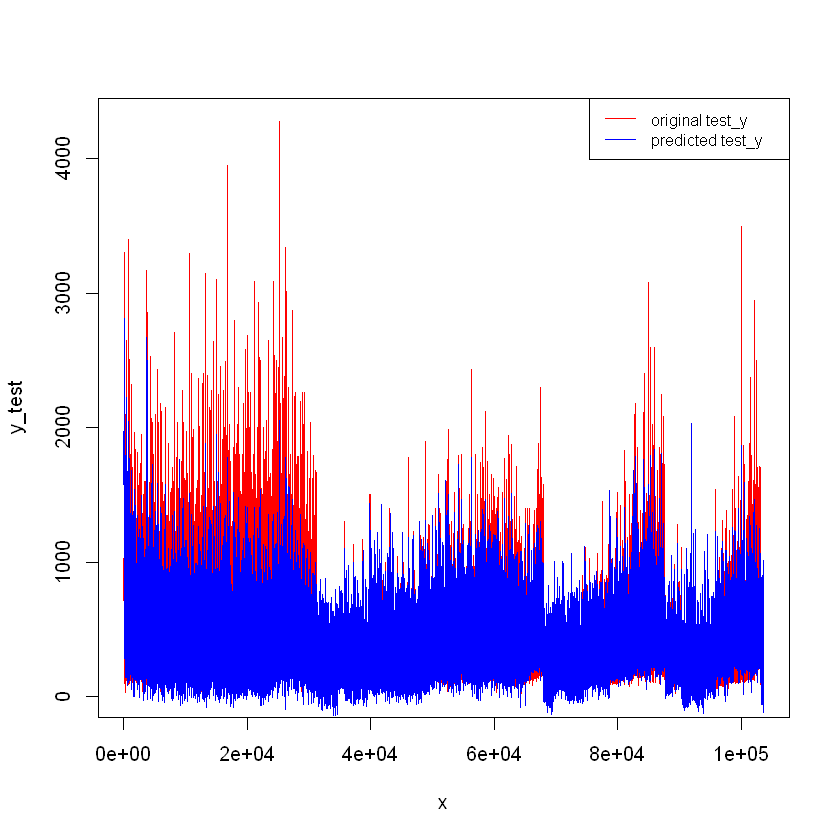

In [62]:
x = 1:length(y_test)
plot(x, y_test, col = "red", type = "l")
lines(x, pred_y_xgbr, col = "blue", type = "l")
legend("topright",  legend = c("original test_y", "predicted test_y"), 
       col = c("red", "blue"), box.lty = 1, cex = 0.8, lty = c(1, 1))

In [63]:
save(xgb.reg, file = "models/xgbr_model.rda")
save(xgb.reg, file = "../house-price-prediction-app/shinyApp/models/xgbr_model.rda")